### 0. Utilities

#### Imports

In [1]:
from enum import Enum
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
# Reading from a cleaned NACE CSV
NACE_df = pd.read_csv("data/exports/NACE.csv")

# Basic text processing for inferencing ISIC codes using NACE codes as indices
NACE_df["Code"] = NACE_df["Code"].str.replace(".", "")
NACE_df = NACE_df.set_index("Code")
NACE_df = NACE_df.fillna("")

NACE_df.head()

,Level,Parent,Description,Examples,Exclusions,ISIC code
Code,,,,,,
A,1,,"AGRICULTURE, FORESTRY AND FISHING",This section includes the exploitation of vege...,,A
01,2,A,"Crop and animal production, hunting and relate...","This division includes two basic activities, n...",Agricultural activities exclude any subsequent...,01
011,3,01,Growing of non-perennial crops,This group includes the growing of non-perenni...,,011
0111,4,01.1,"Growing of cereals (except rice), leguminous c...",This class includes all forms of growing of ce...,"This class excludes: - growing of rice, see 01...",0111
0112,4,01.1,Growing of rice,This class includes: - growing of rice (includ...,,0112


#### Custom types

In [3]:
# Industry classification standards (ICSs)
class IndustryStandard(Enum):
    NACE = "NACE"
    ISIC = "ISIC"
    WZ = "WZ"
    SSIC = "SSIC"

# Industry classification codes
class IndustryCode:
    def __init__(self, std: IndustryStandard, value: str):
        self.std = std
        self.value = value
        
    def __eq__(self, other):
        if isinstance(other, self.__class__):
            if (self.std == IndustryStandard.NACE and other.std == IndustryStandard.ISIC) or (self.std == IndustryStandard.ISIC and other.std == IndustryStandard.NACE):
                return NACE_df.loc[code.value, "ISIC code"] == other.value
            
            return self.std == other.std and self.value == other.value
        
        return False

    def __ne__(self, other):
        return not self.__eq__(other)

#### Constants

In [4]:
# ICSs as a list
ind_stds = [std for std in IndustryStandard]

# Non-NACE standards
non_nace_stds = ind_stds[1:]

# Roles of companies in industrial symbiosis
old_roles = ("Providing", "Intermediate", "Receiving")

# New roles (for readability)
roles = ("Donor", "Intermediary", "Receiver")

# Standard code difference threshold, 't'
DIFF_THRESHOLD = 10

#### Helper functions

##### Obtaining column names

In [5]:
# Obtain column name based on the imported MAESTRI dataset, given ICS and company role
old_col = lambda std, role: f"{std.value} code - {role} industry"

# Obtain concise column name, given ICS and company role
new_col = lambda std, role: f"{role} {std.value} code"

# Obtain column name for similarity score, given ICS and company role
similarity_col = lambda std, role: f"{role} {std.value} code sim. score"

##### Similarity score ('s') calculation

**ASSUMPTION:** If the difference of codes of the same level is within a given threshold, then they are equal.

In [6]:
# Ensure the strings are of comparable length
def comparable_codes(lst):
    min_len = min([len(code.value) for code in lst])
    return [IndustryCode(code.std, code.value[:min_len]) for code in lst]

# Compare two codes
def compare(code1: IndustryCode, code2: IndustryCode):
    if code1 != code2:
        diff = abs(int(code1.value) - int(code2.value))
        return 1 if diff <= DIFF_THRESHOLD else 0
    
    return True

# Compare a code with a list of codes
def compare_one_to_many(code1: IndustryCode, codes):
    codes = comparable_codes([code1, *codes])[1:]
    scores = [compare(code1, code) for code in codes]
    
    return str(sum(scores) / len(scores))

# Compare a list of codes with another list of codes
def compare_many(codes1, codes2):
    lst = [comparable_codes([code1, code2]) for code1, code2 in zip(codes1, codes2)]
    lst = [tuple(l) for l in lst]
    
    scores = [compare(code1, code2) for code1, code2 in lst]
    return str(sum(scores) / len(scores))

In [7]:
# Evaluate similarity score based on NACE code and another standard code
def similarity_score(nace_code_str, std_code_str, std):
    # If code does not exist
    if nace_code_str == "" or std_code_str == "":
        return ""
    
    # Split the text by either ';' or ','
    
    ## NACE code
    if ";" in nace_code_str:
        nace_codes = [IndustryCode(IndustryStandard.NACE, text) for text in nace_code_str.split(";")]
    elif "," in nace_code_str:
        nace_codes = [IndustryCode(IndustryStandard.NACE, text) for text in nace_code_str.split(";")]
    else:
        nace_codes = [IndustryCode(IndustryStandard.NACE, nace_code_str)]
    
    ## Standard code
    if ";" in std_code_str:
        std_codes = [IndustryCode(std, text) for text in std_code_str.split(";")]
    elif "," in std_code_str:
        std_codes = [IndustryCode(std, text) for text in std_code_str.split(",")]
    else:
        std_codes = [IndustryCode(std, std_code_str)]
    
    if len(nace_codes) == len(std_codes):
        return compare_many(nace_codes, std_codes)
    elif len(nace_codes) > 1 and len(std_codes) == 1:
        return compare_one_to_many(std_codes[0], nace_codes)
    elif len(nace_codes) == 1 and len(std_codes) > 1:
        return compare_one_to_many(nace_codes[0], std_codes)
    
    return ""

### 1. Reading the MAESTRI dataset

#### Importing the spreadsheet

In [8]:
# Read the MAESTRI dataset as a DataFrame
maestri_df = pd.read_excel("data/Exchanges-database Maestri.xlsx", sheet_name="MAESTRI", dtype=str)

# Replace NaN values with empty strings
maestri_df = maestri_df.fillna("")

# Remove carets, asterisks and hashes
maestri_df.replace([r"\^|\*|#"], "", regex=True, inplace=True)

#### Split the main dataset into DataFrames for each role (i.e., provider, intermediary, receiver)

In [9]:
# Aggregate relevant column names for data validation
cols_list = [[old_col(std, role) for std in ind_stds] for role in old_roles]

# Obtain subsets within the original dataset for validation
test_dfs = [maestri_df[cols].copy() for cols in cols_list]

# Rename columns within subsets
for i in range(len(roles)):
    col_dict = dict()
    old_role = old_roles[i]
    new_role = roles[i]
    
    for std in ind_stds:
        k = old_col(std, old_role)
        v = new_col(std, new_role)
        
        col_dict.update({k: v})
    
    test_dfs[i] = test_dfs[i].rename(columns=col_dict)
    
    # Drop rows with null values for the NACE code
    # Source: https://stackoverflow.com/questions/29314033/drop-rows-containing-empty-cells-from-a-pandas-dataframe
    std = ind_stds[i + 1]
    test_dfs[i] = test_dfs[i][   test_dfs[i][new_col(std, new_role)].astype(bool)   ]

In [10]:
test_dfs[0].head()

,Donor NACE code,Donor ISIC code,Donor WZ code,Donor SSIC code
0,1920,1920,19200,19201
1,1920,1920,19200,19201
2,2410,2410,24520,24310
3,2410,2410,24520,24310
4,2351,2394,23510;23650;23610,23940


### 2. Obtaining similarity scores for validation

In [11]:
# Loop through all company types
for i in range(len(roles)):
    # Role: either 'Donor', 'Intermediary' or 'Receiver'
    role = roles[i]
    
    # NACE column, example: 'Provider NACE code'
    nace_col = new_col(ind_stds[0], role)
    
    # Iterate through all standards except NACE as it is to be compared with
    for std in non_nace_stds:
        df = test_dfs[i]
        
        # Standard column, example for ISIC: 'Donor ISIC code'
        std_col = new_col(std, role)
        
        # Zip the NACE and standard columns to iterate through
        tuples = zip(df[nace_col], df[std_col])
        
        # Append the similarity score column of a certain standard to the DataFrame for a given role
        df[similarity_col(std, role)] = [similarity_score(*a, std) for a in tuples]
        
        # Convert the similarity score column data type to 'float'
        df[similarity_col(std, role)] = df[similarity_col(std, role)].astype(float)
    
    # List containing new order of columns for readability
    cols = [nace_col] + [f(std, role) for std in non_nace_stds for f in (new_col, similarity_col)]
    
    # Reorder columns for readability
    test_dfs[i] = test_dfs[i][cols]

NameError: name 'code' is not defined

In [ ]:
test_dfs[0].head()

,Donor NACE code,Donor ISIC code,Donor ISIC code sim. score,Donor WZ code,Donor WZ code sim. score,Donor SSIC code,Donor SSIC code sim. score
0,1920,1920,1.0,19200,1.000000,19201,1.0
1,1920,1920,1.0,19200,1.000000,19201,1.0
2,2410,2410,1.0,24520,0.000000,24310,0.0
3,2410,2410,1.0,24520,0.000000,24310,0.0
4,2351,2394,1.0,23510;23650;23610,0.666667,23940,0.0


### 3. Visualising similarity scores

In [ ]:
# Bar width for every plot
bar_width = 0.3

# Categories
categories = ["s = 0", "0 < s < 1", "s = 1"]

# Determine counts for a given series
get_counts = lambda f: lambda x: {
    "s = 0": [len(arr[arr == 0]) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) for arr in f(x)]
}

# Determine percents for a given series
get_percents = lambda f: lambda x: {
    "s = 0": [len(arr[arr == 0]) / len(arr) for arr in f(x)],
    "0 < s < 1": [len(arr[(arr > 0) & (arr < 1)]) / len(arr) for arr in f(x)],
    "s = 1": [len(arr[arr == 1]) / len(arr) for arr in f(x)]
}

#### By company role and industry classification standard

In [ ]:
# Function to extract all scores by role
scores_by_role = lambda std: [np.array(df[similarity_col(std, role)]) for role, df in zip(roles, test_dfs)]

# Function to calculate score count breakdown (by role)
scores_counts_by_role = get_counts(scores_by_role)

# Function to calculate score percentage (by role) breakdown
scores_percents_by_role = get_percents(scores_by_role)

In [ ]:
# Create a subplot based on a given ICS
def score_subplot(std, ax, is_percent=True):
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = scores_percents_by_role(std) if is_percent else scores_counts_by_role(std)
    
    # Initial bar heights
    bottom = np.zeros(len(values_dict))
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for category, values in values_dict.items():
        # Add bars for each category for all roles ('Donor', 'Intermediary', 'Receiver')
        ax.bar(roles, values, bar_width, label=category, bottom=bottom)
        
        # Increment the base bar heights
        bottom += values
    
    # Set the title of the subplot
    ax.set_title(std.value)
    
    # Rotate the x-ticks by 45 degrees
    ax.tick_params(axis="x", labelrotation=45)
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

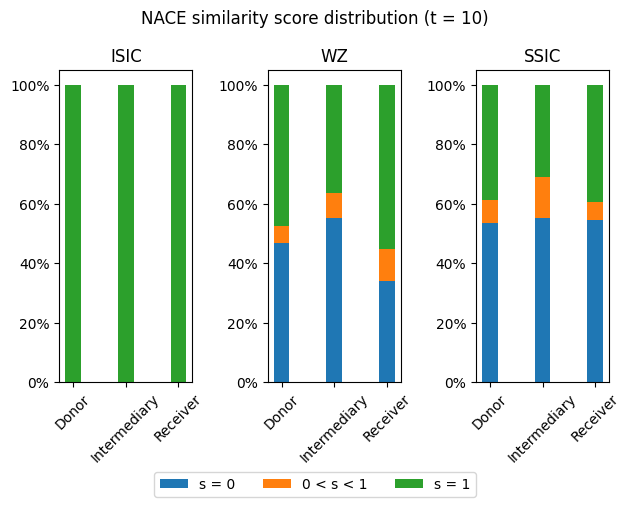

In [ ]:
fig, axs = plt.subplots(ncols=len(non_nace_stds))

# Add subplots for each standard
for std, ax in zip(non_nace_stds, axs):
    score_subplot(std, ax)

# Add a legend to the figure
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(roles), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"NACE similarity score distribution (t = {DIFF_THRESHOLD})")

# Add enough padding between subplots to prevent overlapping
fig.tight_layout()

plt.show()

#### By industry classification standard

In [ ]:
# Function to extract the scores of a given standard
scores_std = lambda std: np.concatenate(scores_by_role(std))

# Function to extract the scores of a set of standards
scores = lambda stds: [scores_std(std) for std in stds]

# Score count breakdown
score_counts_dict = get_counts(scores)(non_nace_stds)

# Score percentage breakdown
score_percents_dict = get_percents(scores)(non_nace_stds)

In [ ]:
# Create a subplot based on a given ICS
def score_plot(ax, is_percent=True):
    # x-axis values
    x = [std.value for std in non_nace_stds]
    
    # Obtain the dictionary with the breakdown of values by similarity score
    values_dict = score_percents_dict if is_percent else score_counts_dict
    
    # Initial bar heights
    bottom = np.zeros(len(values_dict))
    
    # Looping through each category ('s = 0', '0 < s < 1', 's = 1')
    for std, values in values_dict.items():
        # Add bars for each category for all standards ('ISIC', 'WZ', 'SSIC')
        ax.bar(x, values, bar_width, label=std, bottom=bottom)
        
        # Increment the base bar heights
        bottom += values
    
    # If the type of plot is a percentage plot,
    if is_percent:
        # format the y-axis to be percentage values
        ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

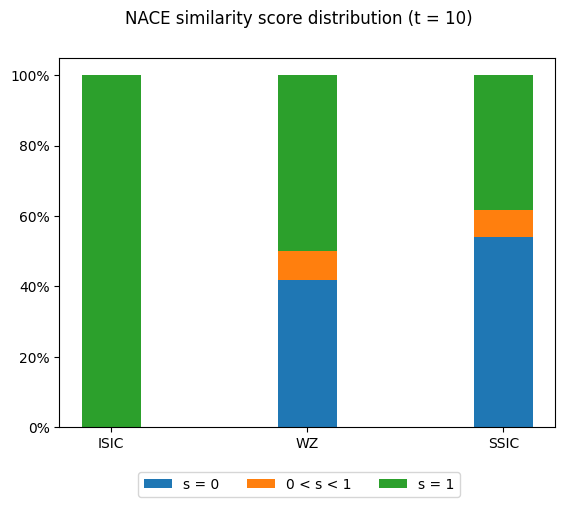

In [ ]:
fig, ax = plt.subplots()

# Add bars to the figure
score_plot(ax)

# Add a legend to the figure
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, ncol=len(non_nace_stds), loc="lower center", bbox_to_anchor=[0.5, -0.05])

# Set the title of the figure
fig.suptitle(f"NACE similarity score distribution (t = {DIFF_THRESHOLD})")

plt.show()

### 4. Exporting results to Excel

In [ ]:
with pd.ExcelWriter("data/exports/Exchanges-database Maestri_accuracy.xlsx") as writer:
    for i in range(len(test_dfs)):
        role = roles[i]
        df = test_dfs[i]
        
        df.to_excel(writer, sheet_name=role, index=False)
        worksheet = writer.sheets[role]
        workbook = writer.book
        
        format = workbook.add_format()
        format.set_align('left')
        format.set_align('vcenter')
        
        # Loop through all columns
        for index, col in enumerate(df):
            series = df[col]
            max_len = max((
                series.astype(str).map(len).max(),  # Length of largest item
                len(str(series.name))               # Length of column name/header
            ))
            
            # Set column width
            worksheet.set_column(index, index, max_len, format)